<a href="https://colab.research.google.com/github/Surakshyaluitel/suru.demo/blob/main/flooddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORT LIBRARIES
# =================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, roc_auc_score
)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving suru flood.csv to suru flood.csv


In [ ]:
# STEP 1: LOAD DATA
# ============================
df = pd.read_csv("suru flood.csv")

# Convert FloodProbability to binary Flood_Occurred
df['Flood_Occurred'] = (df['FloodProbability'] >= 0.5).astype(int)

# Check for missing values in each column
print(df.isnull().sum())

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
Flood_Occurred                     0
dtype: int64


Flood_Occurred
1    25513
0    24487
Name: count, dtype: int64


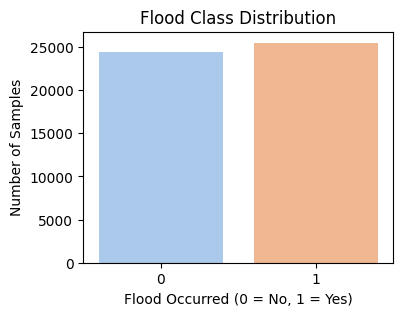

In [ ]:
# Balanced flood occurrence classes

print(df['Flood_Occurred'].value_counts())

plt.figure(figsize=(4, 3))
sns.countplot(x='Flood_Occurred', hue='Flood_Occurred', data=df, palette='pastel', legend=False)
plt.title("Flood Class Distribution")
plt.xlabel("Flood Occurred (0 = No, 1 = Yes)")
plt.ylabel("Number of Samples")
plt.show()

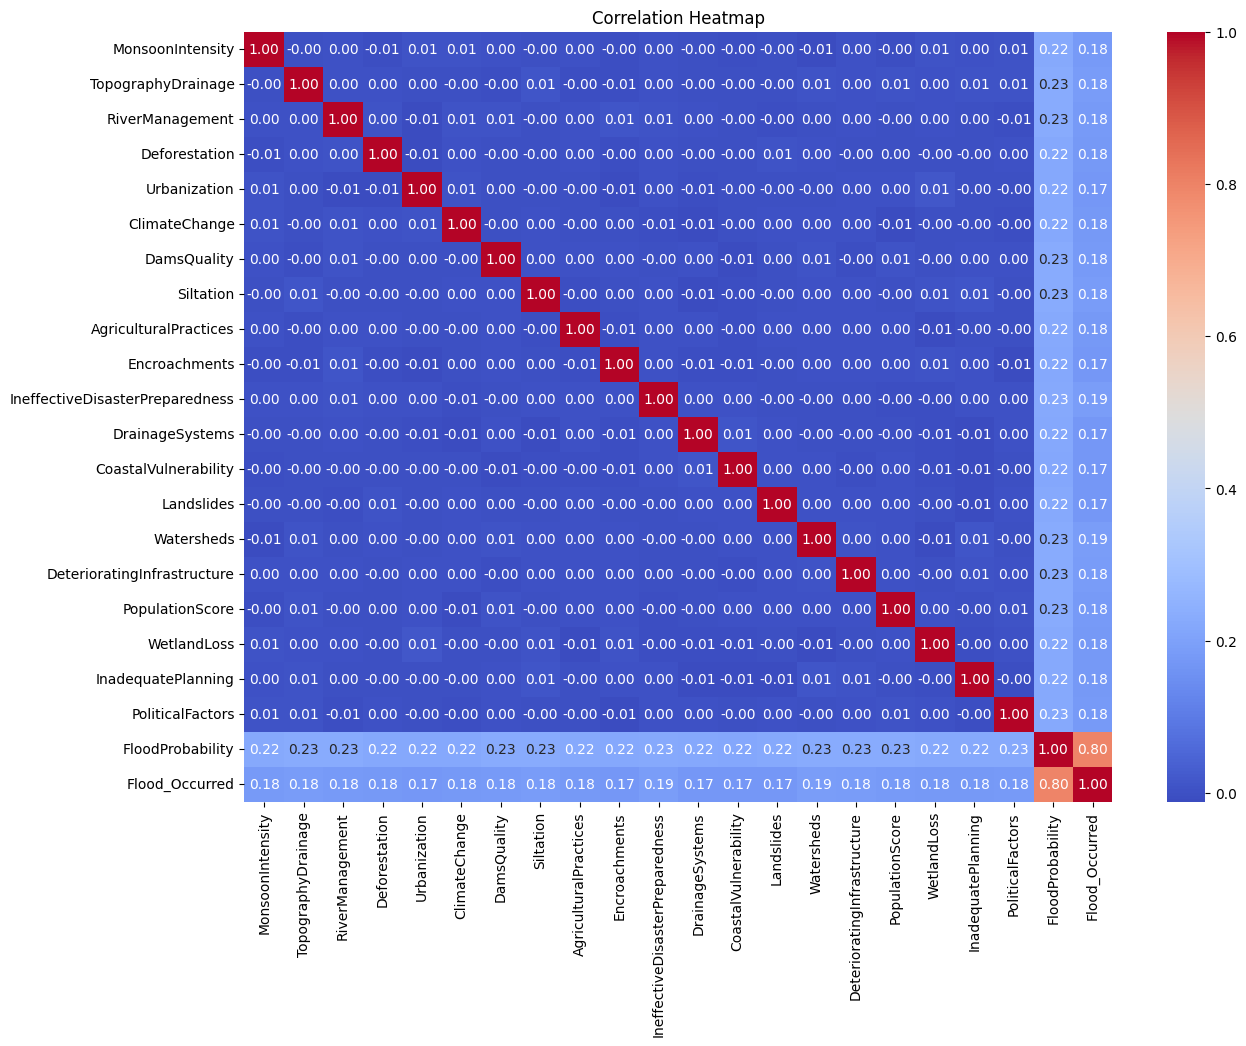

In [ ]:
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# =============================

# 1. Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


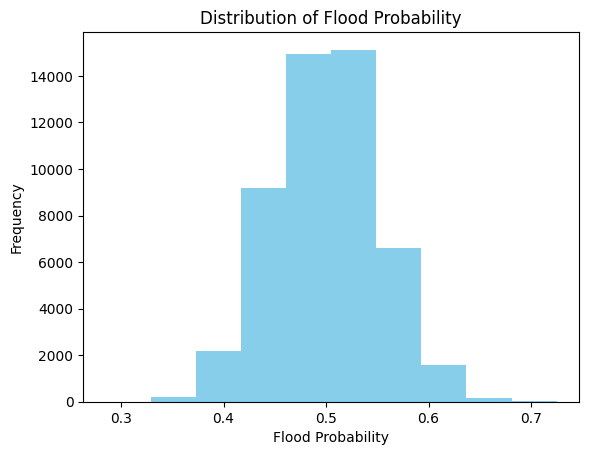

In [ ]:
# 2. Histogram of Flood Probability
plt.hist(df['FloodProbability'], bins=10, color='skyblue')
plt.xlabel("Flood Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Flood Probability")
plt.show()

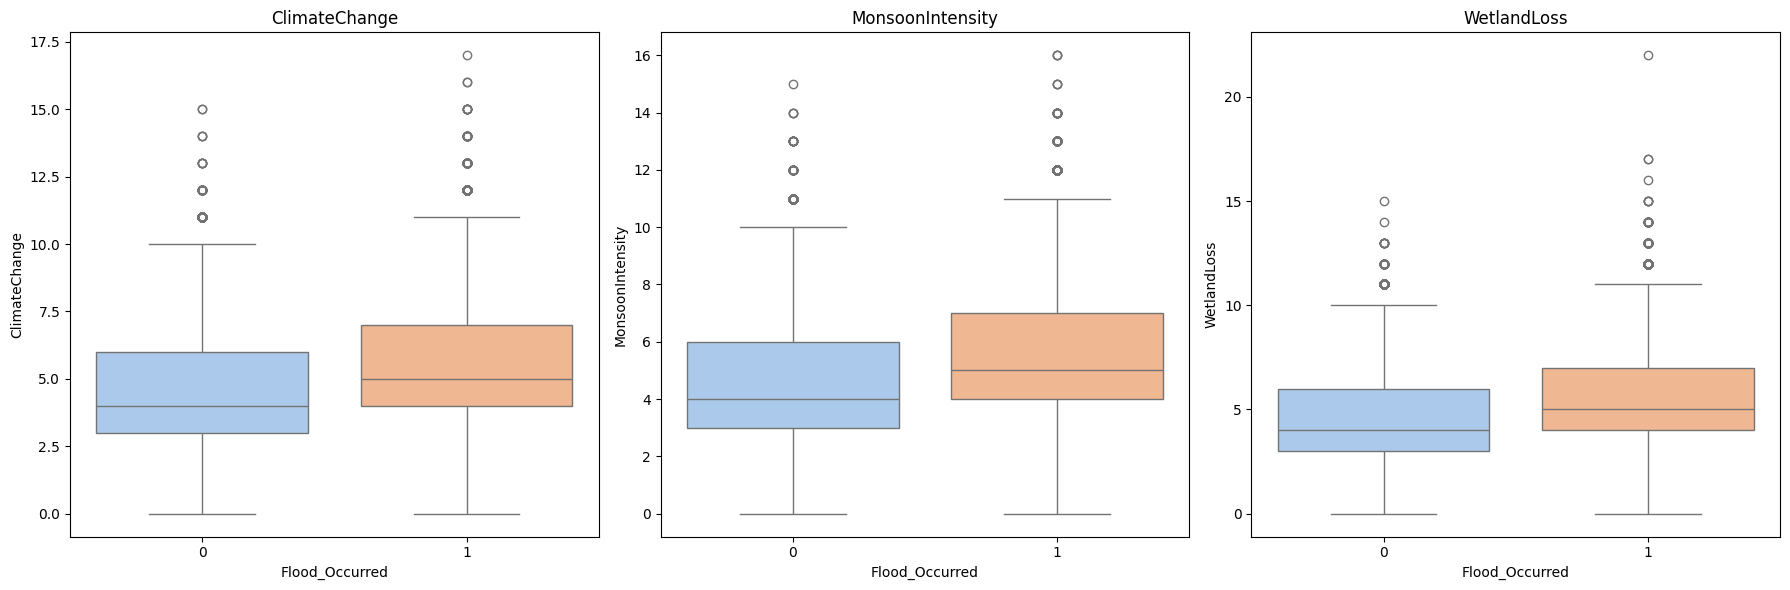

In [ ]:
# 3. Boxplots for selected features
plt.figure(figsize=(18, 6))
for i, f in enumerate(['ClimateChange', 'MonsoonIntensity', 'WetlandLoss'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Flood_Occurred', hue='Flood_Occurred', y=f, data=df, palette='pastel', legend=False)
    plt.title(f)
plt.tight_layout()
plt.show()

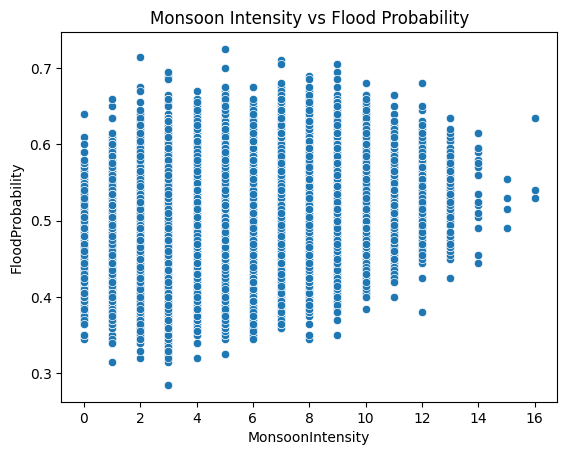

In [ ]:
# 4.Scatter plot to check feature relationship

sns.scatterplot(x='MonsoonIntensity', y='FloodProbability', data=df)
plt.title('Monsoon Intensity vs Flood Probability')
plt.show()


In [ ]:
# STEP 3: DATA PREPARATION
# =============================

X = df.drop(columns=['FloodProbability', 'Flood_Occurred'])
y = df['Flood_Occurred']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [ ]:
# STEP 4: RANDOM FOREST TRAINING
# =============================
# ----- Single-core -----

start = time.time()
model1 = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
model1.fit(X_train, y_train)
train_time_1 = time.time() - start

start = time.time()
pred1 = model1.predict(X_test)
latency_1 = (time.time() - start) / len(X_test) * 1000
acc1 = accuracy_score(y_test, pred1)

In [ ]:
# ----- Multi-core -----

start = time.time()
model2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model2.fit(X_train, y_train)
train_time_2 = time.time() - start

start = time.time()
pred2 = model2.predict(X_test)
latency_2 = (time.time() - start) / len(X_test) * 1000
acc2 = accuracy_score(y_test, pred2)

In [ ]:
# STEP 5: PERFORMANCE REPORT
# =============================
print("\n--- Accuracy Comparison ---\n")
print(f"Single-core   → Time: {train_time_1:.2f}s | Accuracy: {acc1:.4f} | Latency: {latency_1:.4f} ms/sample")
print(f"Parallel-core → Time: {train_time_2:.2f}s | Accuracy: {acc2:.4f} | Latency: {latency_2:.4f} ms/sample")


--- Accuracy Comparison ---

Single-core   → Time: 15.50s | Accuracy: 0.9044 | Latency: 0.0236 ms/sample
Parallel-core → Time: 5.93s | Accuracy: 0.9044 | Latency: 0.0187 ms/sample


In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, pred2))


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4821
           1       0.91      0.90      0.91      5179

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



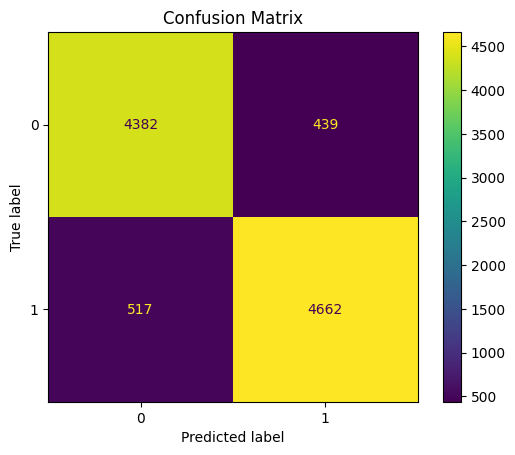

In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

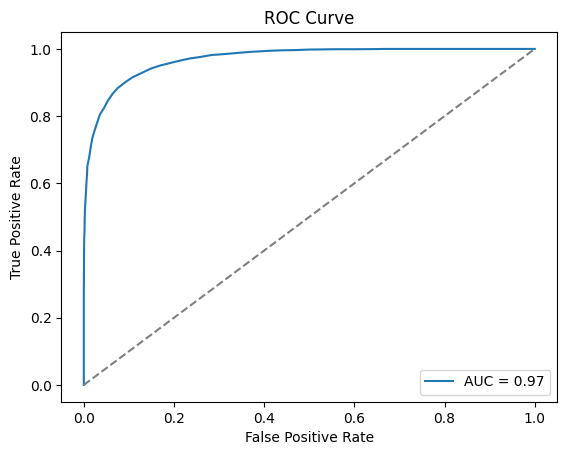

In [ ]:
# STEP 6: ROC CURVE
# =============================
y_prob = model2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=5)

print("CV Accuracy:", scores)
print("Mean Accuracy:", scores.mean())


CV Accuracy: [0.9053 0.898  0.8952 0.9037 0.8953]
Mean Accuracy: 0.8995
